# Model Optimization

In this part, I am going to work with logistic regression.  
First, I'll do some features selections, then I'll work on the parameters optimization

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('../input/processed_train.csv')

In [3]:
X = np.array(df.drop(['PassengerId','Survived'], axis=1))
y = np.array(df['Survived'])
X.shape

(891, 37)

In [4]:
clf = LogisticRegression()

In [6]:
# get base line for accuracy
from sklearn.model_selection import cross_val_score
lr = LogisticRegression()
scores = cross_val_score(lr, X, y, cv=9, scoring='accuracy')
print('Accuracy = %.3f' % scores.mean())

Accuracy = 0.827


## Features Selection

In [6]:
from sklearn.feature_selection import RFE
from sklearn import model_selection

In [7]:
def get_best_features(model, X, y):
    ''' find the n best features to train the model
    parameters
    ----------
        model    object
            a supervised learning estimator
        X    array
            training set
        y    array
            target values
    output
    ------
        X_best    array
            the array of best features
    '''
    
    num_fold = 10
    seed = 7
    scoring = 'accuracy'
    best_cv = 0
    best_mask = []
    
    kfold = model_selection.KFold(n_splits = num_fold,
                                  random_state = seed)
    
    for i in range(1,X.shape[1] + 1):
        rfe = RFE(model,i)
        X_new = rfe.fit_transform(X,y)
        cv_results = model_selection.cross_val_score(model, X_new, y,
                                                    cv = kfold,
                                                    scoring = scoring)
        score = cv_results.mean()
        
        if score > best_cv:
            X_best = X_new
            best_mask = rfe.get_support(False)
            best_cv = score
        #print('n = %f -> score = %f' % (i,score))
    
    return X_best, best_mask

    #print('best score = %f' % best_cv)
    #print('best i = %f' % X_best.shape[1])

In [8]:
X_best, mask = get_best_features(clf, X, y)
X_best.shape

(891, 21)

In [9]:
print(mask)

[False  True False False False  True False  True  True  True  True False
 False  True  True  True  True  True  True  True False False  True False
  True  True  True False False False False  True  True False  True False
  True]


## parameters optimization

In [10]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, X, y, param_grid):
    ''' get the parameters that return the best score
    parameters
    ----------
        model object
            a supervised learning estimator
        X    array
            training set
        y    array
            target values
        param_grid    dictionary
            the list of parameters and their possible values
    output
    ------
        best_params    dictionary
            the best value for each parameter in initial list
    '''
    
    scoring = 'accuracy'
    cv = 10
    
    grid = GridSearchCV(clf, 
                        param_grid,
                        scoring = scoring,
                        n_jobs = 1,
                        cv = cv)
    
    grid.fit(X,y)
    
    print(grid.best_score_)
    print(grid.best_estimator_)

In [11]:
param_grid = {'solver': ['liblinear','newton-cg','lbfgs'],
              'penalty': ['l2'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'fit_intercept': [True,False],
              'intercept_scaling':[0.001, 0.01, 0.1, 1, 10, 100, 1000]
              }

get_best_params(clf,X_best,y,param_grid)

0.836139169473
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


## train the model

In [12]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import metrics 

clf = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=.2)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [13]:
clf.score(X_test,y_test)

0.79329608938547491

In [14]:
cm = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])
print(cm)
print(metrics.classification_report(y_test, predictions))

Predicted   0   1
Actual           
0          94  16
1          21  48
             precision    recall  f1-score   support

          0       0.82      0.85      0.84       110
          1       0.75      0.70      0.72        69

avg / total       0.79      0.79      0.79       179



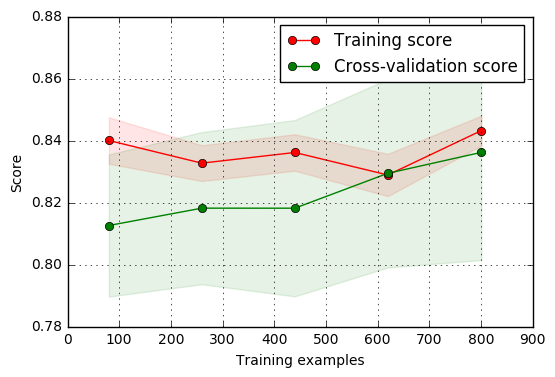

In [15]:
import matplotlib.pyplot as plt
train_sizes, train_scores, test_scores = learning_curve(lr, X_best, \
                                                        y, \
                                                        cv=10, \
                                                        train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.figure()
plt.grid()

plt.fill_between(train_sizes, 
                train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std,
                alpha=0.1, color='r')
plt.fill_between(train_sizes, 
                test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std,
                alpha=0.1, color='g')

plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
         label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
         label='Cross-validation score')

plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()  

## submit

In [16]:
test = pd.read_csv('../input/processed_test.csv')
X_sub = np.array(test.drop(['PassengerId'], axis=1))

In [17]:
X_sub = X_sub[:,mask]

In [18]:
y_sub = clf.predict(X_sub)
submission = pd.DataFrame({'PassengerId': test['PassengerId'],
                           'Survived': y_sub})
submission.to_csv('../output/tmlc_20161229.csv')